In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re
import swifter
import pickle
from wordcloud import WordCloud
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

d:\Sentiment_Analysis_TeePublic\sent_venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [52]:
data = pd.read_csv("D:\Sentiment_Analysis_TeePublic\TeePublic_review.csv", encoding = 'ISO-8859-1')
data.info()
data.head(5)

<>:1: SyntaxWarning: invalid escape sequence '\S'
<>:1: SyntaxWarning: invalid escape sequence '\S'
C:\Users\Evita\AppData\Local\Temp\ipykernel_28148\509814027.py:1: SyntaxWarning: invalid escape sequence '\S'
  data = pd.read_csv("D:\Sentiment_Analysis_TeePublic\TeePublic_review.csv", encoding = 'ISO-8859-1')


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 278100 entries, 0 to 278099
Data columns (total 10 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   reviewer_id     278099 non-null  float64
 1   store_location  278100 non-null  object 
 2   latitude        278100 non-null  float64
 3   longitude       278100 non-null  float64
 4   date            278100 non-null  int64  
 5   month           278100 non-null  int64  
 6   year            278100 non-null  object 
 7   title           278088 non-null  object 
 8   review          247597 non-null  object 
 9   review-label    278100 non-null  int64  
dtypes: float64(3), int64(3), object(4)
memory usage: 21.2+ MB


,reviewer_id,store_location,latitude,longitude,date,month,year,title,review,review-label
0,0.0,US,37.090240,-95.712891,2023,6,2015 00:00:00,Great help with lost order,I had an order that was lost in transit. When ...,5
1,1.0,US,37.090240,-95.712891,2023,6,2024 00:00:00,I ordered the wrong size tee and hadï¿½ï¿½ï¿½,I ordered the wrong size tee and had difficult...,5
2,2.0,US,37.090240,-95.712891,2023,6,2017 00:00:00,These guys offer the best customerï¿½ï¿½ï¿½,These guys offer the best customer service in ...,5
3,3.0,US,37.090240,-95.712891,2023,6,2024 00:00:00,Good Stuff,Looked for an obscure phrase on a shirt. Teepu...,5
4,4.0,CA,56.130366,-106.346771,2023,6,2023 00:00:00,My order arrived in a good timelyï¿½ï¿½ï¿½,My order arrived in a good timely fashion & th...,4


In [53]:
#Checking for null values
data.isnull().sum()

reviewer_id           1
store_location        0
latitude              0
longitude             0
date                  0
month                 0
year                  0
title                12
review            30503
review-label          0
dtype: int64

In [54]:
#dropping the null values
data = data.dropna(subset = ['review', 'reviewer_id', 'title'])
data

,reviewer_id,store_location,latitude,longitude,date,month,year,title,review,review-label
0,0.0,US,37.090240,-95.712891,2023,6,2015 00:00:00,Great help with lost order,I had an order that was lost in transit. When ...,5
1,1.0,US,37.090240,-95.712891,2023,6,2024 00:00:00,I ordered the wrong size tee and hadï¿½ï¿½ï¿½,I ordered the wrong size tee and had difficult...,5
2,2.0,US,37.090240,-95.712891,2023,6,2017 00:00:00,These guys offer the best customerï¿½ï¿½ï¿½,These guys offer the best customer service in ...,5
3,3.0,US,37.090240,-95.712891,2023,6,2024 00:00:00,Good Stuff,Looked for an obscure phrase on a shirt. Teepu...,5
4,4.0,CA,56.130366,-106.346771,2023,6,2023 00:00:00,My order arrived in a good timelyï¿½ï¿½ï¿½,My order arrived in a good timely fashion & th...,4
...,...,...,...,...,...,...,...,...,...,...
278094,278094.0,US,37.090240,-95.712891,2018,4,2027 00:00:00,Great site,Great site. Supports independent artists while...,5
278095,278095.0,US,37.090240,-95.712891,2018,4,2027 00:00:00,Highly recommend!,"Delivery is quick, arrives when promised. Shir...",5
278096,278096.0,HR,45.100000,15.200000,2018,4,2027 00:00:00,Great quality,"Great quality, fast delivery, would recommend!",5
278097,278097.0,US,37.090240,-95.712891,2018,4,2027 00:00:00,Dudes rock.,Dudes rock. Seriously.,5


In [55]:
# Create sentiment labels
def label_sentiment(rating):
    if rating in [4, 5]:
        return 'Positive'
    elif rating == 3:
        return 'Neutral'
    else:
        return 'Negative'
    
#Apply the function to the 'review-label' column
data['Sentiment'] = data['review-label'].apply(label_sentiment)

# Count the number of each sentiment
sentiment_counts = data['Sentiment'].value_counts()
print(sentiment_counts)
data.tail()

Sentiment
Positive    204369
Negative     27475
Neutral      15743
Name: count, dtype: int64


,reviewer_id,store_location,latitude,longitude,date,month,year,title,review,review-label,Sentiment
278094,278094.0,US,37.09024,-95.712891,2018,4,2027 00:00:00,Great site,Great site. Supports independent artists while...,5,Positive
278095,278095.0,US,37.09024,-95.712891,2018,4,2027 00:00:00,Highly recommend!,"Delivery is quick, arrives when promised. Shir...",5,Positive
278096,278096.0,HR,45.10000,15.200000,2018,4,2027 00:00:00,Great quality,"Great quality, fast delivery, would recommend!",5,Positive
278097,278097.0,US,37.09024,-95.712891,2018,4,2027 00:00:00,Dudes rock.,Dudes rock. Seriously.,5,Positive
278098,278098.0,US,37.09024,-95.712891,2018,4,2027 00:00:00,Shipping was fast the T-shirt was justï¿½ï¿½ï¿½,Shipping was fast the T-shirt was just right g...,5,Positive


## Reducing the number of data

In [56]:
# Extract year and convert to numeric
data['year'] = data['year'].astype(str).str.extract(r'(\d{4})')
data['year'] = pd.to_numeric(data['year'], errors='coerce')

# Keep only rows with valid year ≤ 2025
data = data[data['year'].notna() & (data['year'] <= 2025)]


In [57]:
positive_df = data[data['Sentiment'] == 'Positive']
positive_df = positive_df.head(30000)
negative_df = data[data['Sentiment'] == 'Negative']
negative_df = negative_df
neutral_df = data[data['Sentiment'] == 'Neutral']
neutral_df = neutral_df

data = pd.concat([positive_df,negative_df,neutral_df], ignore_index=True)
print(data['Sentiment'].value_counts())
data.info()

Sentiment
Positive    30000
Negative    22501
Neutral     12920
Name: count, dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65421 entries, 0 to 65420
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   reviewer_id     65421 non-null  float64
 1   store_location  65421 non-null  object 
 2   latitude        65421 non-null  float64
 3   longitude       65421 non-null  float64
 4   date            65421 non-null  int64  
 5   month           65421 non-null  int64  
 6   year            65421 non-null  int64  
 7   title           65421 non-null  object 
 8   review          65421 non-null  object 
 9   review-label    65421 non-null  int64  
 10  Sentiment       65421 non-null  object 
dtypes: float64(3), int64(4), object(4)
memory usage: 5.5+ MB


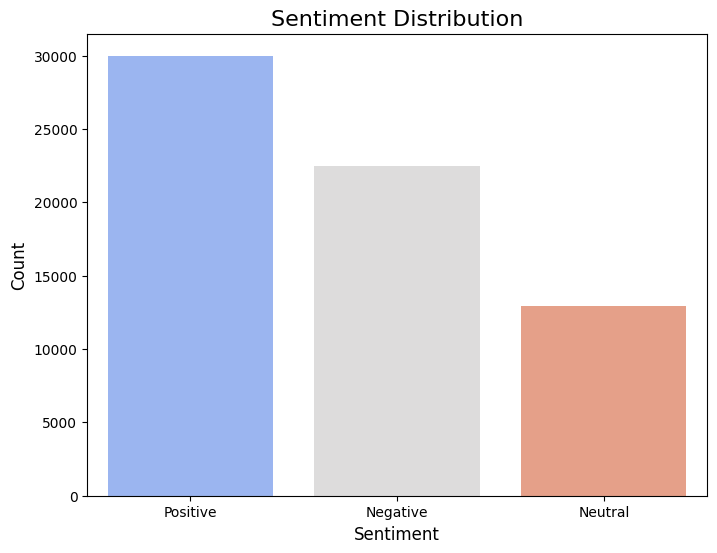

In [58]:
import matplotlib.pyplot as plt
import seaborn as sns

# Sentiment Distribution
plt.figure(figsize=(8, 6))
sns.countplot(x='Sentiment', data=data, palette='coolwarm')
plt.title('Sentiment Distribution', fontsize=16)
plt.xlabel('Sentiment', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.show()


In [59]:
data.isnull().sum()

reviewer_id       0
store_location    0
latitude          0
longitude         0
date              0
month             0
year              0
title             0
review            0
review-label      0
Sentiment         0
dtype: int64

In [60]:
data.to_csv('Reduced_Data.csv', index=False)

In [61]:
#Function to clean text
def clean_text(text):
    if isinstance(text, str):  # Check if the input is a string
        text = re.sub(r'[^A-Za-z\s]', '', text)  # Remove special characters and numbers
        text = text.lower()  # Convert to lowercase
        text = ' '.join([word for word in text.split() if word not in stopwords.words('english')])  # Remove stop words
        return text
    else:
        return '' 

data['clean_review'] = data['review'].swifter.apply(clean_text)

Pandas Apply: 100%|██████████| 65421/65421 [03:58<00:00, 274.76it/s]


## Word Cloud for the Sentiments

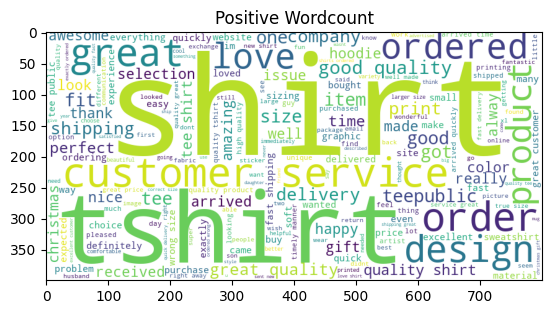

In [62]:
positive_txt = ''.join(data[data['Sentiment'] == 'Positive']['clean_review'])
positive_wc = WordCloud(width = 800, height = 400, background_color = 'white').generate(positive_txt)
plt.title('Positive Wordcount')
plt.imshow(positive_wc)

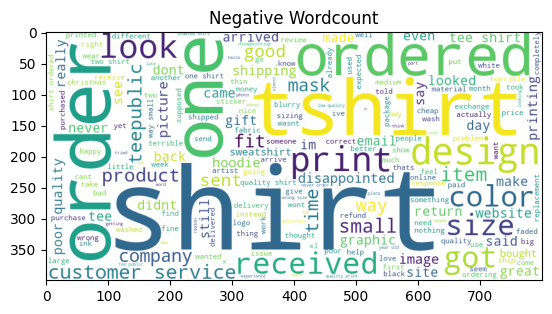

In [63]:
negative_txt = ''.join(data[data['Sentiment'] == 'Negative']['clean_review'])
negative_wc = WordCloud(width = 800, height = 400, background_color = 'white').generate(negative_txt)
plt.title('Negative Wordcount')
plt.imshow(negative_wc)

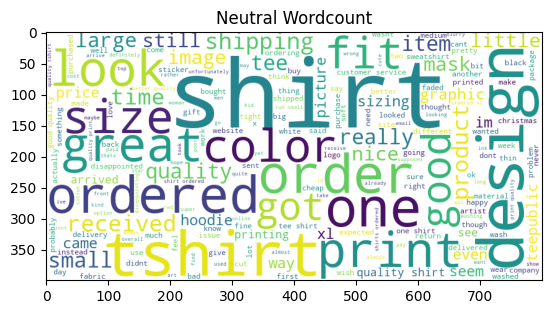

In [64]:
neutral_txt = ''.join(data[data['Sentiment'] == 'Neutral']['clean_review'])
neutral_wc = WordCloud(width = 800, height = 400, background_color = 'white').generate(neutral_txt)
plt.title('Neutral Wordcount')
plt.imshow(neutral_wc)

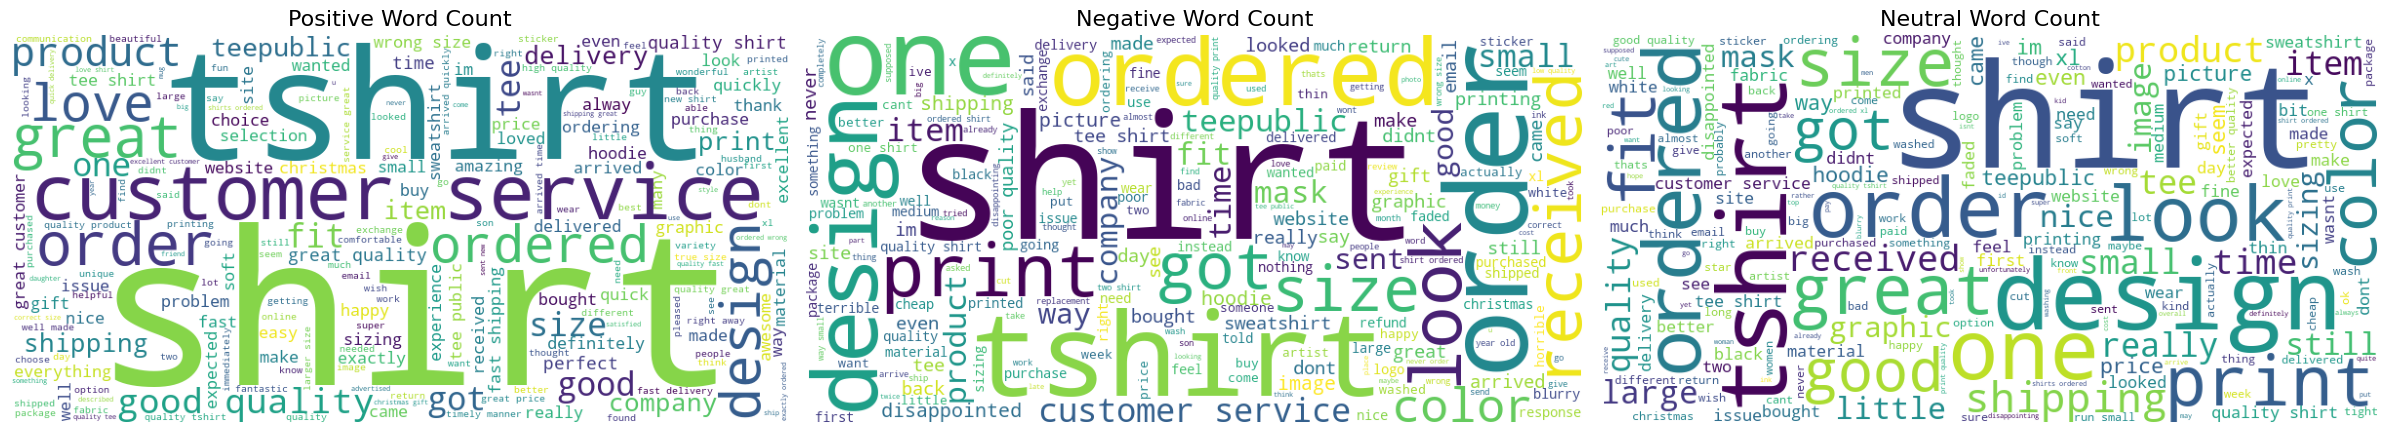

In [65]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# Generate word clouds for each sentiment
positive_txt = ''.join(data[data['Sentiment'] == 'Positive']['clean_review'])
positive_wc = WordCloud(width=800, height=400, background_color='white').generate(positive_txt)

negative_txt = ''.join(data[data['Sentiment'] == 'Negative']['clean_review'])
negative_wc = WordCloud(width=800, height=400, background_color='white').generate(negative_txt)

neutral_txt = ''.join(data[data['Sentiment'] == 'Neutral']['clean_review'])
neutral_wc = WordCloud(width=800, height=400, background_color='white').generate(neutral_txt)

# Create subplots to place all word clouds in one figure
fig, axs = plt.subplots(1, 3, figsize=(24, 8))

# Positive word cloud
axs[0].imshow(positive_wc)
axs[0].set_title('Positive Word Count', fontsize=16)
axs[0].axis('off')  # Hide axes

# Negative word cloud
axs[1].imshow(negative_wc)
axs[1].set_title('Negative Word Count', fontsize=16)
axs[1].axis('off')  # Hide axes

# Neutral word cloud
axs[2].imshow(neutral_wc)
axs[2].set_title('Neutral Word Count', fontsize=16)
axs[2].axis('off')  # Hide axes

# Show the figure with all 3 word clouds
plt.tight_layout()
plt.show()

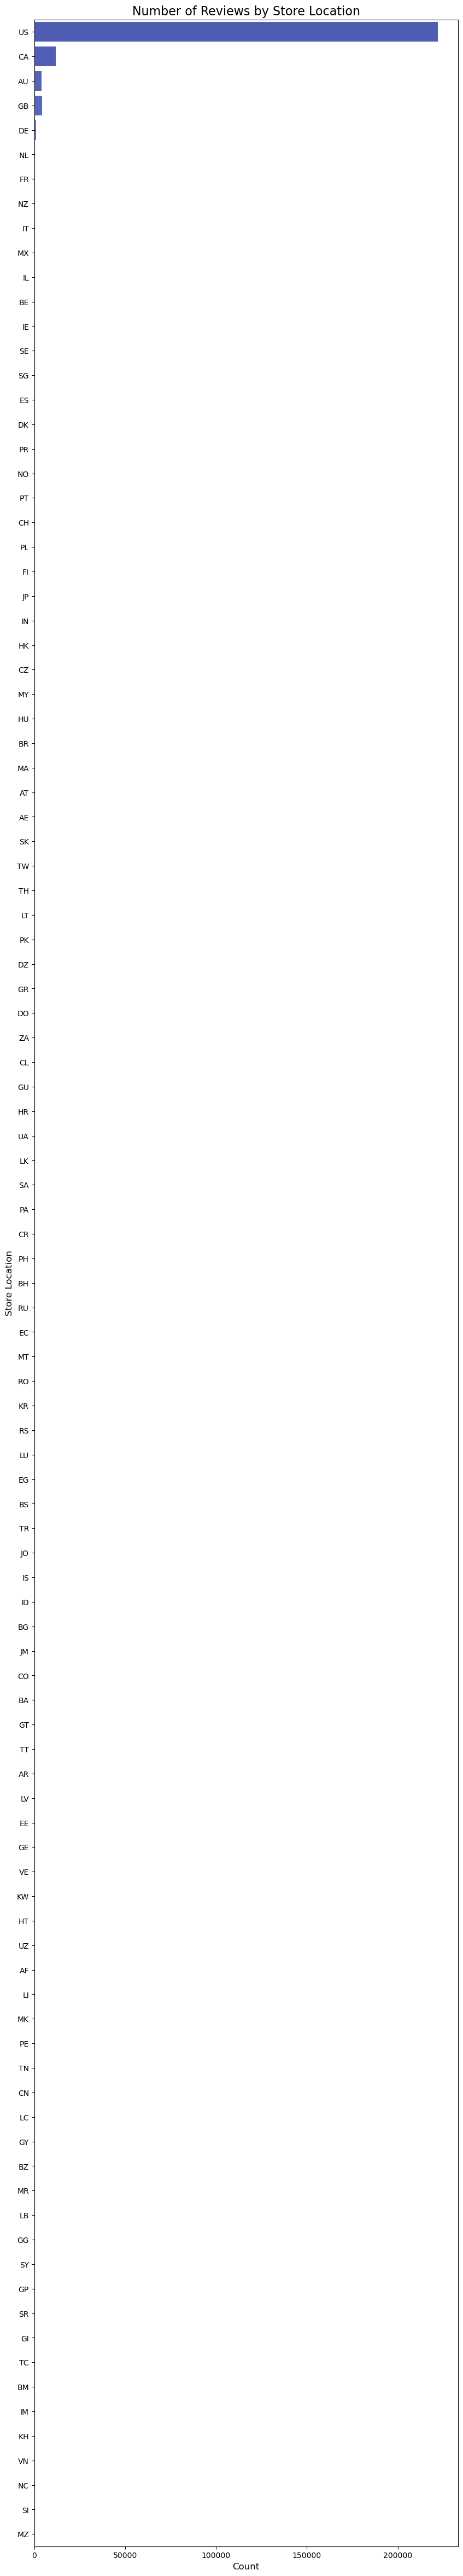

In [21]:
plt.figure(figsize=(10, 60))
sns.countplot(y='store_location', data=df, palette='coolwarm', order=data['store_location'].value_counts().index)
plt.title('Number of Reviews by Store Location', fontsize=16)
plt.xlabel('Count', fontsize=12)
plt.ylabel('Store Location', fontsize=12)
plt.show()


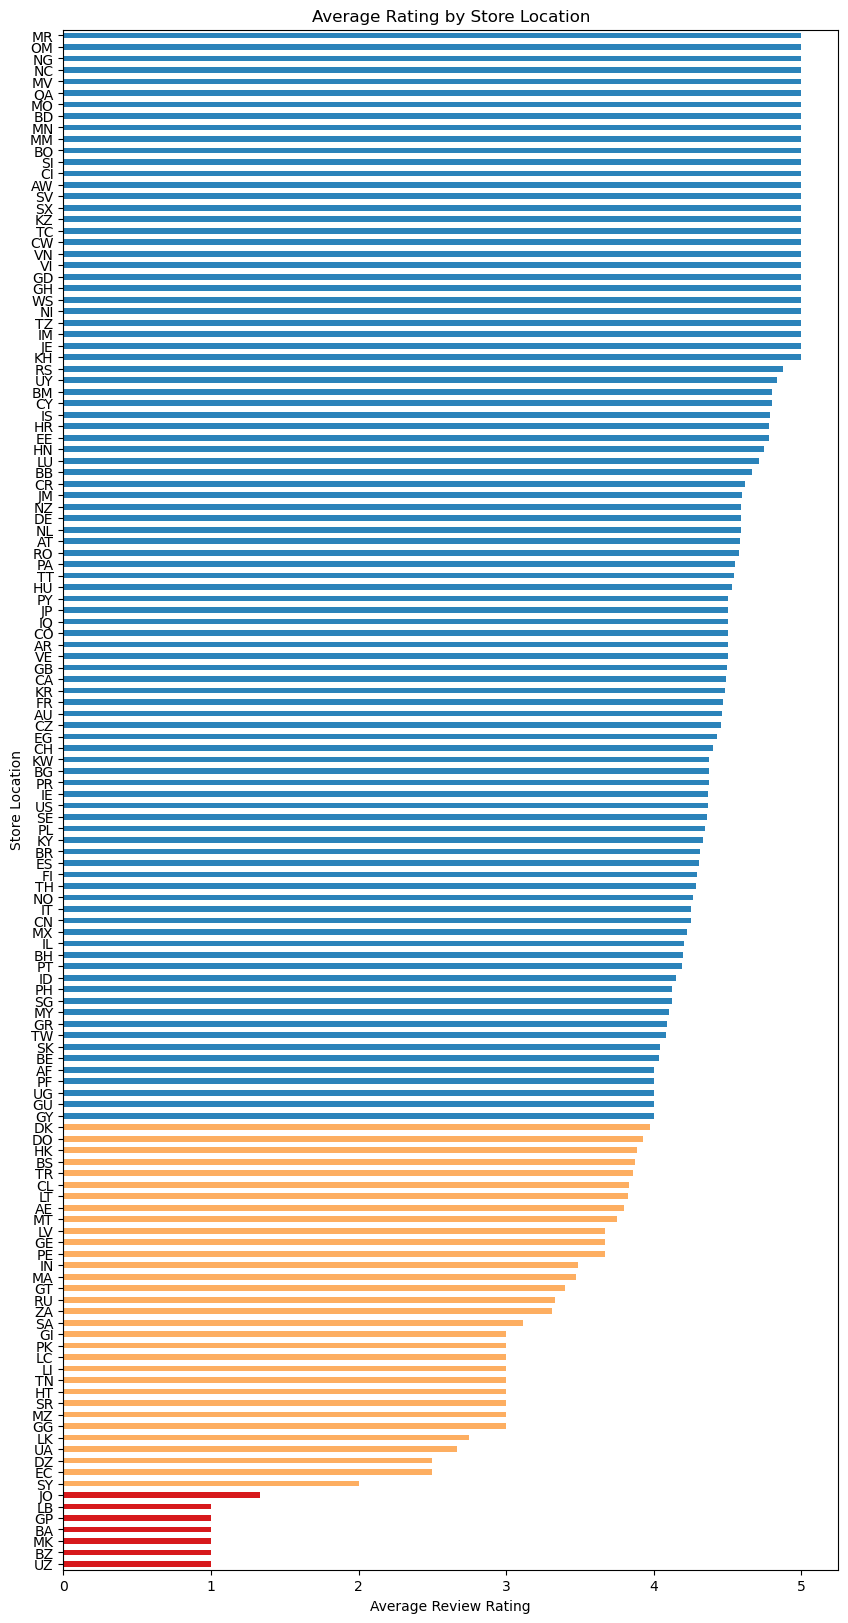

In [25]:
import matplotlib.pyplot as plt
import pandas as pd

# Group by store_location to get average rating per store
avg_rating_per_store = df.groupby('store_location')['review-label'].mean().sort_values()

# Define colors based on rating range
colors = ['#d7191c' if rating < 2 else '#fdae61' if rating < 4 else '#2b83ba' for rating in avg_rating_per_store]

# Plot
plt.figure(figsize=(10, 20))
avg_rating_per_store.plot(kind='barh', color=colors)
plt.title('Average Rating by Store Location')
plt.xlabel('Average Review Rating')
plt.ylabel('Store Location')
plt.show()


In [66]:
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(data['clean_review'])  # X is the feature matrix
y = data['Sentiment']

In [67]:
# Split data into training and test sets 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [68]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state = 42)
X_retrain,y_retrain = smote.fit_resample(X_train,y_train)

In [69]:
# Train the model - Logistic Regression
model_log = LogisticRegression(class_weight='balanced', max_iter=1500)
model_log.fit(X_retrain, y_retrain)

# Predict on the test set
y_pred = model_log.predict(X_test)

# Evaluate the model
print(classification_report(y_test, y_pred))
print("Accuracy:", (accuracy_score(y_test, y_pred)*100),0.2)

              precision    recall  f1-score   support

    Negative       0.77      0.74      0.75      4537
     Neutral       0.47      0.55      0.51      2601
    Positive       0.91      0.86      0.89      5947

    accuracy                           0.76     13085
   macro avg       0.71      0.72      0.71     13085
weighted avg       0.77      0.76      0.76     13085

Accuracy: 75.83492548719907 0.2


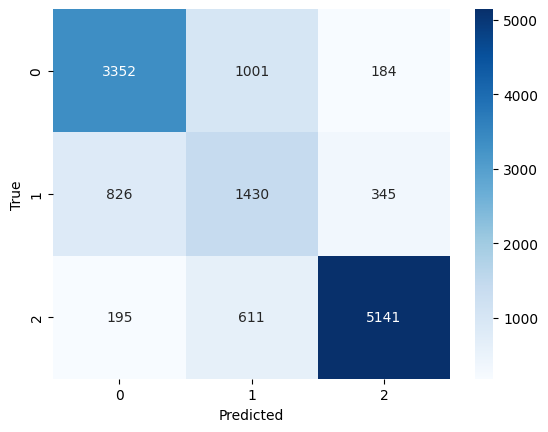

In [70]:
# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [71]:
# Train the model - Multinomial NB
model = MultinomialNB(alpha = 1.0)
model.fit(X_retrain, y_retrain)

#predict on the test set
y_pred = model.predict(X_test)

# Evaluate the model
print(classification_report(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))

              precision    recall  f1-score   support

    Negative       0.76      0.68      0.72      4537
     Neutral       0.47      0.64      0.54      2601
    Positive       0.94      0.86      0.90      5947

    accuracy                           0.76     13085
   macro avg       0.72      0.73      0.72     13085
weighted avg       0.78      0.76      0.77     13085

Accuracy: 0.7561329766908674


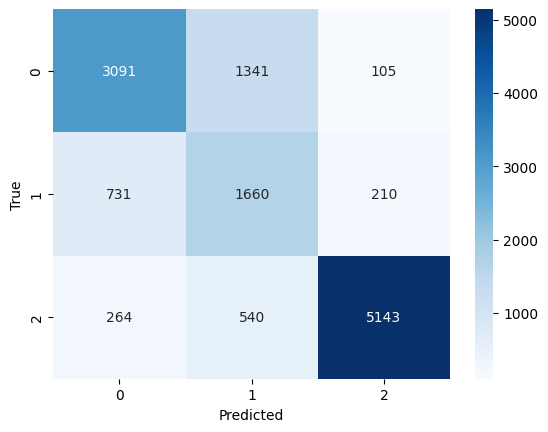

In [72]:
# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [73]:
clean_text('Absolutely delighted with the purchase, everything is fantastic!')

'absolutely delighted purchase everything fantastic'

In [74]:
v = vectorizer.transform(['Absolutely delighted with the purchase, everything is fantastic!'])
v

<Compressed Sparse Row sparse matrix of dtype 'int64'
	with 5 stored elements and shape (1, 44258)>

In [75]:
#Using Multinomial NB
txt = input()
CleanTxt =clean_text(txt)
CleanTxt = vectorizer.transform([CleanTxt])
pred = model.predict(CleanTxt)
pred[0]

np.str_('Negative')

In [28]:
txt = input()
CleanTxt =clean_text(txt)
CleanTxt = vectorizer.transform([CleanTxt])
pred = model.predict(CleanTxt)
pred[0]


np.str_('Negative')

In [30]:
#Using Logistic Regression
txt = input()
CleanTxt2 =clean_text(txt)
CleanTxt2 = vectorizer.transform([CleanTxt2])
p = model_log.predict(CleanTxt2)
p[0]

'Neutral'

In [76]:
with open('vectorizer.pkl', 'wb') as file:
    pickle.dump(vectorizer, file)

In [77]:
with open('sentiment_model.pkl', 'wb') as file:
    pickle.dump(model, file)

In [78]:
with open('SentimentModel.pkl', 'wb') as file:
    pickle.dump(model_log, file)